
# Moving Average Crossover + ML Filter (yfinance, pandas, scikit-learn, ta, matplotlib)

This notebook implements a classic **moving average (MA) crossover** strategy and an **ML-filtered** version using a simple classifier.  
It uses **trusted libraries** widely adopted in data science and quant research:

- **yfinance** for data sourcing (Yahoo Finance historical prices)  
- **pandas** / **numpy** for data manipulation and vectorized calculations  
- **ta** for technical indicators (MACD, RSI, Bollinger Bands)  
- **scikit-learn** for a time-series-aware cross-validation and a Gradient Boosting classifier  
- **matplotlib** for plotting  
- (Optional) **warnings**, **dataclasses** for clean utilities

**What you get**
1. Baseline MA(20/100) long-only crossover backtest (vectorized).
2. ML model trained **only** on entry (cross-up) events to predict if the next N-day return is positive.
3. A filtered backtest that only takes entries with ML probability above a threshold.
4. Risk metrics: CAGR, Sharpe (annualized), Max Drawdown, Total Return.
5. Clean plots and a CSV export of equity curves.

> Tip: Run the installation cell first if your environment is missing any packages.


In [3]:

# If running locally or in a fresh environment, uncomment and run:
# %pip install --quiet yfinance pandas numpy scikit-learn ta matplotlib


In [8]:

import warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from dataclasses import dataclass

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

# Technical indicators (ta)
try:
    from ta.trend import MACD
    from ta.momentum import RSIIndicator
    from ta.volatility import BollingerBands
except Exception:
    MACD = RSIIndicator = BollingerBands = None

plt.rcParams["figure.figsize"] = (10, 5)  # single chart per cell per instructions


In [20]:

# ------------------------------- Parameters -------------------------------- #
TICKER = "MSFT"          # change to your preferred ticker
START = "2010-01-01"
SHORT_WINDOW = 20
LONG_WINDOW  = 100

SLIPPAGE_BPS = 1.0      # slippage per trade event in basis points
RISK_FREE = 0.015       # 1.5% annualized risk-free for Sharpe
ML_HOLD_DAYS = 10       # forward horizon for ML label
PROBA_THRESHOLD = 0.55  # only enter trades if ML prob > threshold
# --------------------------------------------------------------------------- #


In [ ]:

def cagr(equity, periods_per_year=252):
    if len(equity) < 2:
        return np.nan
    total_ret = equity.iloc[-1] / equity.iloc[0] - 1
    years = len(equity) / periods_per_year
    return (1 + total_ret) ** (1/years) - 1 if years > 0 else np.nan

def sharpe(returns, rf=RISK_FREE, periods_per_year=252):
    if returns.std() == 0 or returns.isna().all():
        return np.nan
    mean_excess = returns.mean() * periods_per_year - rf
    vol = returns.std() * np.sqrt(periods_per_year)
    return mean_excess / (vol + 1e-12)

def max_drawdown(equity):
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return dd.min()

@dataclass
class Metrics:
    cagr: float
    sharpe: float
    max_dd: float
    total_return: float

def compute_metrics(strat_df):
    equity = strat_df["equity"].dropna()
    rets = strat_df["strat_ret"].dropna()
    return Metrics(
        cagr=cagr(equity),
        sharpe=sharpe(rets),
        max_dd=max_drawdown(equity),
        total_return=(equity.iloc[-1] - 1.0) if len(equity) else np.nan
    )

def fetch_prices(ticker=TICKER, start=START):
    df = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    df = df[["Open","High","Low","Close","Volume"]].dropna()
    
    # Flatten MultiIndex columns if they exist
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] for col in df.columns]
    
    return df

def add_indicators(df):
    df = df.copy()
    df["ret"] = df["Close"].pct_change()

    # Rolling means for SMA crossover
    df["sma_s"] = df["Close"].rolling(SHORT_WINDOW).mean()
    df["sma_l"] = df["Close"].rolling(LONG_WINDOW).mean()
    df["sma_diff"] = (df["sma_s"] - df["sma_l"]) / df["sma_l"]

    # Realized vol estimates
    df["rv_10"] = df["ret"].rolling(10).std() * np.sqrt(252)
    df["rv_20"] = df["ret"].rolling(20).std() * np.sqrt(252)

    # Momentum/volume
    df["mom_5"]  = df["Close"].pct_change(5)
    df["mom_10"] = df["Close"].pct_change(10)
    df["mom_20"] = df["Close"].pct_change(20)
    df["vol_z"] = (df["Volume"] - df["Volume"].rolling(20).mean()) / (df["Volume"].rolling(20).std() + 1e-9)

    # Additional indicators via 'ta' 
    if MACD is not None:
        macd = MACD(df["Close"])
        df["macd"] = macd.macd()
        df["macd_sig"] = macd.macd_signal()
        df["macd_diff"] = macd.macd_diff()
    if RSIIndicator is not None:
        rsi = RSIIndicator(df["Close"], window=14)
        df["rsi"] = rsi.rsi()
    if BollingerBands is not None:
        bb = BollingerBands(df["Close"], window=20, window_dev=2)
        df["bb_high"] = bb.bollinger_hband()
        df["bb_low"] = bb.bollinger_lband()
        df["pct_bb"] = (df["Close"] - df["bb_low"]) / (df["bb_high"] - df["bb_low"] + 1e-9)

    return df

def crossover_signals(df):
    df = df.copy()
    df["signal"] = 0
    cross_up   = (df["sma_s"] > df["sma_l"]) & (df["sma_s"].shift(1) <= df["sma_l"].shift(1))
    cross_down = (df["sma_s"] < df["sma_l"]) & (df["sma_s"].shift(1) >= df["sma_l"].shift(1))
    df.loc[cross_up, "signal"] = 1
    df.loc[cross_down, "signal"] = -1

    # Build position series (long-only)
    df["position"] = 0
    pos = 0
    for i in range(len(df)):
        s = df["signal"].iat[i]
        if s == 1:
            pos = 1
        elif s == -1:
            pos = 0
        df["position"].iat[i] = pos
    return df

def apply_slippage(returns, trade_flags, slippage_bps=SLIPPAGE_BPS):
    cost_per_trade = slippage_bps / 1e4
    cost_series = trade_flags.astype(float) * cost_per_trade
    return returns - cost_series

def backtest_long_only(df):
    df = df.copy()
    df["strat_ret"] = df["position"].shift(1) * df["ret"]
    trade = df["position"].diff().abs().fillna(0) > 0
    df["strat_ret"] = apply_slippage(df["strat_ret"], trade)
    df["equity"] = (1 + df["strat_ret"]).cumprod()
    return df

def make_ml_labels(df, horizon=ML_HOLD_DAYS):
    df = df.copy()
    df["fwd_ret_N"] = df["Close"].pct_change(horizon).shift(-horizon)
    events = df[df["signal"] == 1].copy()  # only evaluate entries
    events["label"] = (events["fwd_ret_N"] > 0).astype(int)
    return events

def make_ml_features(df):
    fcols = ["sma_diff","rv_10","rv_20","mom_5","mom_10","mom_20","vol_z"]
    if "macd" in df.columns:   fcols += ["macd","macd_sig","macd_diff"]
    if "rsi" in df.columns:    fcols += ["rsi"]
    if "pct_bb" in df.columns: fcols += ["pct_bb"]
    X = df[fcols].copy().fillna(method="ffill").fillna(method="bfill")
    return X, fcols

def train_ml_filter(df, proba_threshold=PROBA_THRESHOLD, verbose=True):
    X_full, fcols = make_ml_features(df)
    events = make_ml_labels(df)
    X = X_full.loc[events.index]
    y = events["label"]

    tscv = TimeSeriesSplit(n_splits=5)
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("gb", GradientBoostingClassifier(random_state=42))
    ])

    scores = []
    last_test_idx = None
    for train_idx, test_idx in tscv.split(X):
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        scores.append(model.score(X.iloc[test_idx], y.iloc[test_idx]))
        last_test_idx = test_idx

    if verbose:
        print(f"[ML] TimeSeries CV accuracy (mean±std): {np.mean(scores):.3f} ± {np.std(scores):.3f}")
        if last_test_idx is not None:
            y_pred_last = (model.predict_proba(X.iloc[last_test_idx])[:,1] > proba_threshold).astype(int)
            print("\n[ML] Last fold classification report (thresholded):")
            print(classification_report(y.iloc[last_test_idx], y_pred_last, digits=3))

    model.fit(X, y)

    # Probabilities for all dates where features are valid
    proba = pd.Series(index=df.index, dtype=float)
    valid_idx = X_full.dropna().index
    proba.loc[valid_idx] = model.predict_proba(X_full.loc[valid_idx])[:,1]
    return proba

def backtest_with_ml_filter(df, proba_series, threshold=PROBA_THRESHOLD):
    df = df.copy()
    enter = (df["signal"] == 1) & (proba_series > threshold)
    exit_ = (df["signal"] == -1)

    df["position_ml"] = 0
    pos = 0
    for i in range(len(df)):
        if enter.iat[i]:
            pos = 1
        if exit_.iat[i]:
            pos = 0
        df["position_ml"].iat[i] = pos

    df["strat_ret"] = df["position_ml"].shift(1) * df["ret"]
    trade = df["position_ml"].diff().abs().fillna(0) > 0
    df["strat_ret"] = apply_slippage(df["strat_ret"], trade)
    df["equity"] = (1 + df["strat_ret"]).cumprod()
    return df


## 1) Fetch & Prepare Data

In [22]:
px = fetch_prices(TICKER, START)
df = add_indicators(px)
df = crossover_signals(df).dropna(subset=["sma_s","sma_l"])
df.tail()

,Open,High,Low,Close,Volume,ret,sma_s,sma_l,sma_diff,rv_10,rv_20,mom_5,mom_10,mom_20,vol_z,signal,position
Date,,,,,,,,,,,,,,,,,
2025-08-07,526.799988,528.090027,517.549988,520.840027,16079100,-0.007810,514.520502,449.271687,0.145232,0.272588,0.199683,-0.023730,0.019496,0.038606,-0.429881,0,1
2025-08-08,522.599976,524.659973,519.409973,522.039978,15531000,0.002304,515.456500,450.612209,0.143903,0.271915,0.199588,-0.003950,0.016215,0.037193,-0.486200,0,1
2025-08-11,522.299988,527.590027,519.719971,521.770020,20194400,-0.000517,516.394002,452.001738,0.142460,0.271296,0.199575,-0.025894,0.018088,0.037275,0.000559,0,1
2025-08-12,523.750000,530.979980,522.700012,529.239990,18667000,0.014317,517.565001,453.423044,0.141462,0.277938,0.204070,0.002823,0.032522,0.046301,-0.201763,0,1
2025-08-13,532.109985,532.700012,519.369995,520.580017,19587300,-0.016363,518.313002,454.767533,0.139732,0.295180,0.214516,-0.008306,0.014301,0.029587,-0.120537,0,1


## 2) Baseline MA Crossover Backtest

Baseline: CAGR 14.67% | Sharpe 0.70 | Max DD -32.34%


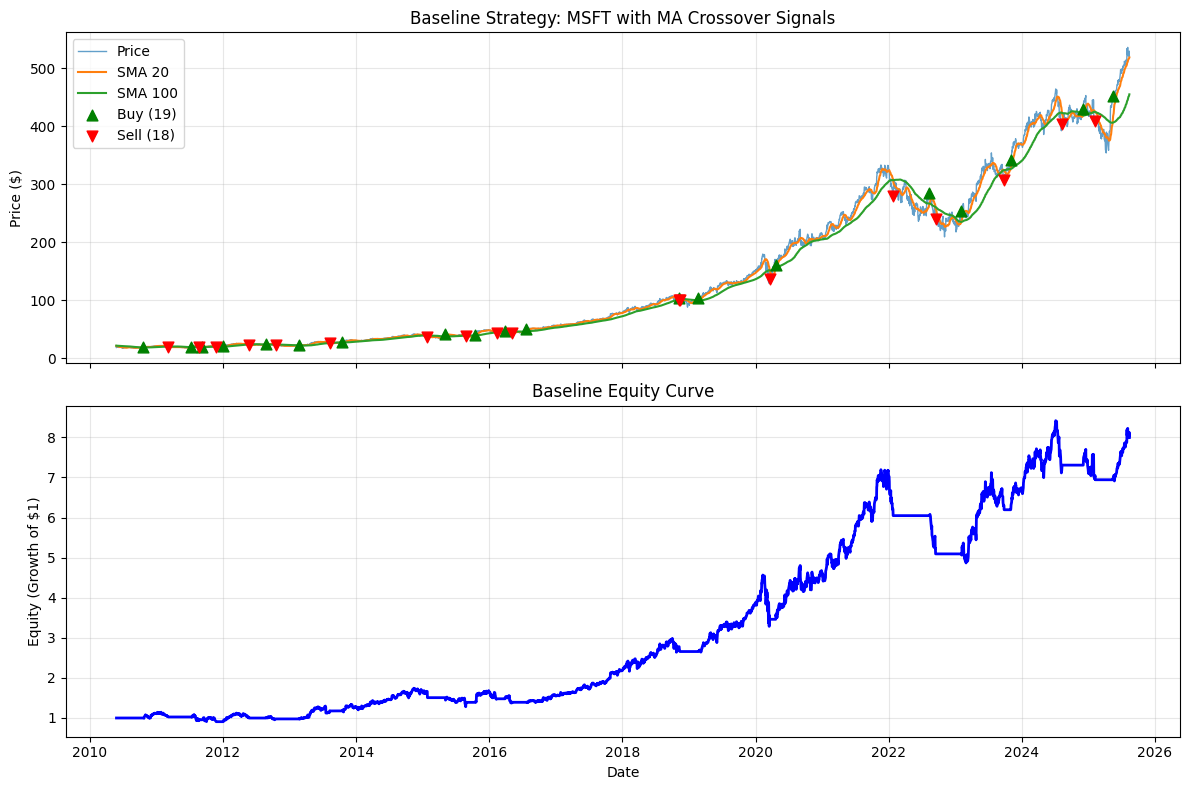

In [27]:

bt_base = backtest_long_only(df)
m_base = compute_metrics(bt_base)
print(f"Baseline: CAGR {m_base.cagr:.2%} | Sharpe {m_base.sharpe:.2f} | Max DD {m_base.max_dd:.2%}")

# Enhanced visualization with signals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: Price with MA lines and signals
ax1.plot(bt_base.index, bt_base["Close"], label="Price", linewidth=1, alpha=0.7)
ax1.plot(bt_base.index, bt_base["sma_s"], label=f"SMA {SHORT_WINDOW}", linewidth=1.5)
ax1.plot(bt_base.index, bt_base["sma_l"], label=f"SMA {LONG_WINDOW}", linewidth=1.5)

# Mark buy/sell signals
buy_signals = bt_base[bt_base["signal"] == 1]
sell_signals = bt_base[bt_base["signal"] == -1]
ax1.scatter(buy_signals.index, buy_signals["Close"], color='green', marker='^', s=60, label=f'Buy ({len(buy_signals)})', zorder=5)
ax1.scatter(sell_signals.index, sell_signals["Close"], color='red', marker='v', s=60, label=f'Sell ({len(sell_signals)})', zorder=5)

ax1.set_ylabel("Price ($)")
ax1.set_title(f"Baseline Strategy: {TICKER} with MA Crossover Signals")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Equity curve
ax2.plot(bt_base.index, bt_base["equity"], color='blue', linewidth=2)
ax2.set_ylabel("Equity (Growth of $1)")
ax2.set_xlabel("Date")
ax2.set_title("Baseline Equity Curve")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3) Train ML Filter on Entry Events

[ML] TimeSeries CV accuracy (mean±std): 0.600 ± 0.249

[ML] Last fold classification report (thresholded):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.333     0.500         3

    accuracy                          0.333         3
   macro avg      0.500     0.167     0.250         3
weighted avg      1.000     0.333     0.500         3



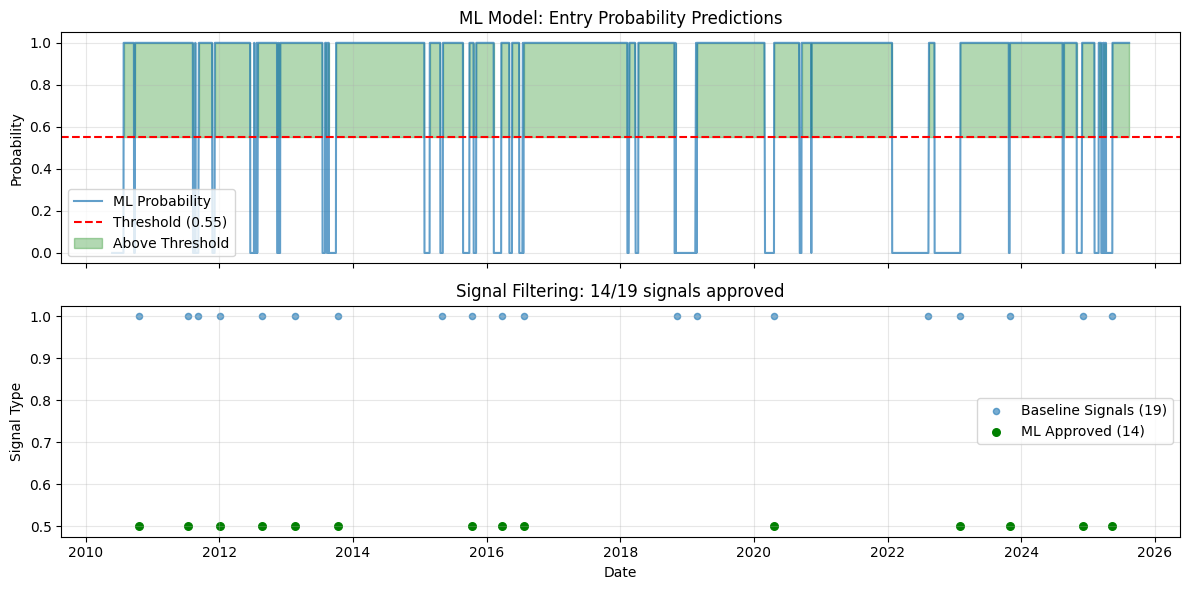

In [28]:

proba = train_ml_filter(df, PROBA_THRESHOLD, verbose=True)

# Visualize ML probabilities and filtering effect
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top: ML probabilities over time
ax1.plot(proba.dropna().index, proba.dropna(), label='ML Probability', alpha=0.7)
ax1.axhline(y=PROBA_THRESHOLD, color='red', linestyle='--', label=f'Threshold ({PROBA_THRESHOLD})')
ax1.fill_between(proba.dropna().index, PROBA_THRESHOLD, proba.dropna(), 
                where=(proba.dropna() > PROBA_THRESHOLD), alpha=0.3, color='green', label='Above Threshold')
ax1.set_ylabel("Probability")
ax1.set_title("ML Model: Entry Probability Predictions")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Signal comparison
baseline_entries = df[df["signal"] == 1]
ax2.scatter(baseline_entries.index, [1]*len(baseline_entries), alpha=0.6, s=20, label=f'Baseline Signals ({len(baseline_entries)})')

# Show which signals would be filtered
filtered_proba = proba.loc[baseline_entries.index].dropna()
approved_signals = baseline_entries.loc[filtered_proba[filtered_proba > PROBA_THRESHOLD].index]
ax2.scatter(approved_signals.index, [0.5]*len(approved_signals), color='green', s=30, label=f'ML Approved ({len(approved_signals)})')

ax2.set_ylabel("Signal Type")
ax2.set_xlabel("Date") 
ax2.set_title(f"Signal Filtering: {len(approved_signals)}/{len(baseline_entries)} signals approved")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4) ML-Filtered Backtest

ML-Filtered: CAGR 15.30% | Sharpe 0.81 | Max DD -19.67%


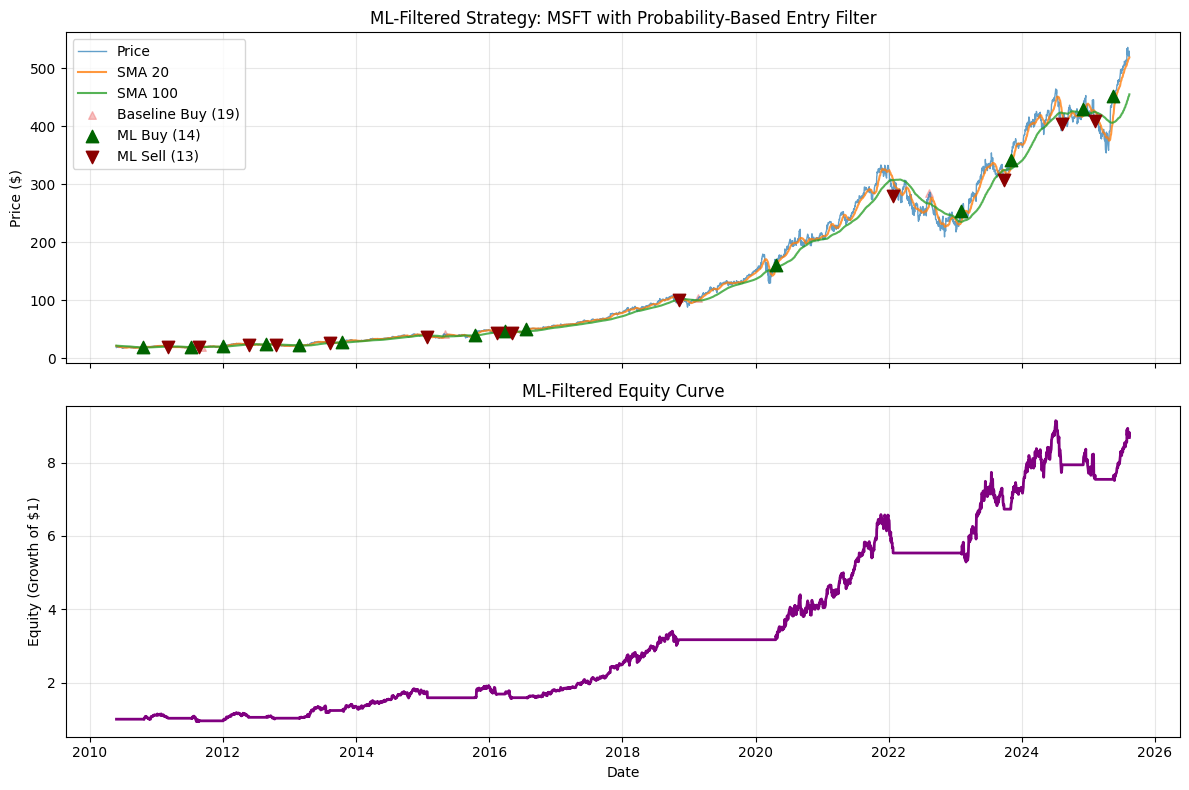

In [29]:

bt_ml = backtest_with_ml_filter(df, proba, PROBA_THRESHOLD)
m_ml = compute_metrics(bt_ml)
print(f"ML-Filtered: CAGR {m_ml.cagr:.2%} | Sharpe {m_ml.sharpe:.2f} | Max DD {m_ml.max_dd:.2%}")

# Enhanced ML strategy visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: Price with ML-filtered signals
ax1.plot(bt_ml.index, bt_ml["Close"], label="Price", linewidth=1, alpha=0.7)
ax1.plot(bt_ml.index, bt_ml["sma_s"], label=f"SMA {SHORT_WINDOW}", linewidth=1.5, alpha=0.8)
ax1.plot(bt_ml.index, bt_ml["sma_l"], label=f"SMA {LONG_WINDOW}", linewidth=1.5, alpha=0.8)

# Show baseline signals (rejected)
baseline_entries = df[df["signal"] == 1]
baseline_exits = df[df["signal"] == -1]
ax1.scatter(baseline_entries.index, baseline_entries["Close"], color='lightcoral', marker='^', 
           s=30, alpha=0.5, label=f'Baseline Buy ({len(baseline_entries)})')

# Show ML-approved signals
ml_entries = bt_ml[bt_ml["position_ml"].diff() == 1]
ml_exits = bt_ml[bt_ml["position_ml"].diff() == -1]
ax1.scatter(ml_entries.index, ml_entries["Close"], color='darkgreen', marker='^', 
           s=80, label=f'ML Buy ({len(ml_entries)})', zorder=5)
ax1.scatter(ml_exits.index, ml_exits["Close"], color='darkred', marker='v', 
           s=80, label=f'ML Sell ({len(ml_exits)})', zorder=5)

ax1.set_ylabel("Price ($)")
ax1.set_title(f"ML-Filtered Strategy: {TICKER} with Probability-Based Entry Filter")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Equity curve
ax2.plot(bt_ml.index, bt_ml["equity"], color='purple', linewidth=2)
ax2.set_ylabel("Equity (Growth of $1)")
ax2.set_xlabel("Date")
ax2.set_title("ML-Filtered Equity Curve")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5) Compare & Export

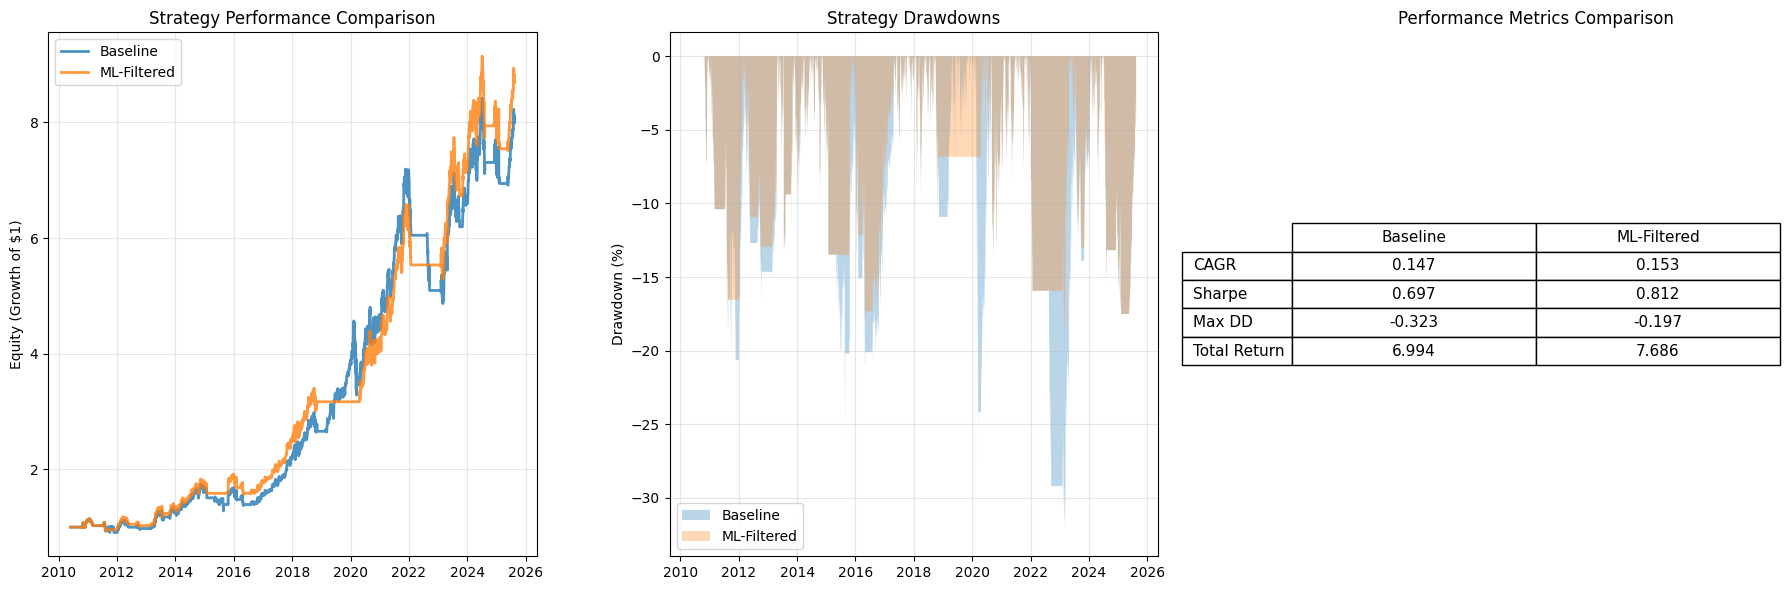

Results saved to equity_curves.csv | Trade count - Baseline: 19, ML: 14


In [ ]:

# Performance comparison
summary = pd.DataFrame({
    "Baseline_Equity": bt_base["equity"],
    "ML_Equity": bt_ml["equity"]
}).dropna()

# Comprehensive comparison visualization
fig = plt.figure(figsize=(15, 10))

# Top row: Two graphs side by side
ax1 = plt.subplot(2, 2, 1)
ax1.plot(summary.index, summary["Baseline_Equity"], label='Baseline', linewidth=2, alpha=0.8)
ax1.plot(summary.index, summary["ML_Equity"], label='ML-Filtered', linewidth=2, alpha=0.8)
ax1.set_ylabel("Equity (Growth of $1)")
ax1.set_title("Strategy Performance Comparison")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 2, 2)
baseline_dd = (bt_base["equity"] / bt_base["equity"].cummax() - 1) * 100
ml_dd = (bt_ml["equity"] / bt_ml["equity"].cummax() - 1) * 100
ax2.fill_between(summary.index, baseline_dd.loc[summary.index], 0, alpha=0.3, label='Baseline')
ax2.fill_between(summary.index, ml_dd.loc[summary.index], 0, alpha=0.3, label='ML-Filtered')
ax2.set_ylabel("Drawdown (%)")
ax2.set_title("Strategy Drawdowns")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Bottom: Performance metrics table (centered)
ax3 = plt.subplot(2, 1, 2)
metrics_comparison = pd.DataFrame({
    'Baseline': [m_base.cagr, m_base.sharpe, m_base.max_dd, m_base.total_return],
    'ML-Filtered': [m_ml.cagr, m_ml.sharpe, m_ml.max_dd, m_ml.total_return]
}, index=['CAGR', 'Sharpe', 'Max DD', 'Total Return'])

ax3.axis('tight')
ax3.axis('off')
table = ax3.table(cellText=metrics_comparison.round(3).values,
                  rowLabels=metrics_comparison.index,
                  colLabels=metrics_comparison.columns,
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)
ax3.set_title("Performance Metrics Comparison", pad=20)

plt.tight_layout()
plt.show()

# Save results
summary.to_csv("equity_curves.csv", index=True)
print(f"Results saved to equity_curves.csv | Trade count - Baseline: {len(bt_base[bt_base['signal']==1])}, ML: {len(bt_ml[bt_ml['position_ml'].diff()==1])}")
